In [36]:
!pip install imblearn

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [38]:
# Loading data
as_df = pd.read_excel('/content/sample_data/AS_final_cleaned_normalized.xlsx')
normal_df = pd.read_excel('/content/sample_data/normal_final_cleaned_normalized.xlsx')

# Adding labels
as_df['AS_label'] = 1
normal_df['AS_label'] = 0

# Combining datasets
df = pd.concat([as_df, normal_df], ignore_index=True)

# Preparing features and target
feature_cols = [col for col in df.columns if col != 'AS_label' and np.issubdtype(df[col].dtype, np.number)]
X = df[feature_cols]
y = df['AS_label']


In [39]:
# Train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [40]:
# Imputing missing values in training and validation/test data (using training statistics)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=feature_cols, index=X_train.index)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=feature_cols, index=X_val.index)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=feature_cols, index=X_test.index)


In [41]:
# Applying SMOTE only on imputed training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train)

print(f"Original training set size: {len(y_train)}")
print(f"Resampled training set size: {len(y_train_resampled)}")
print(f"Original class distribution in train: {np.bincount(y_train)}")
print(f"Balanced class distribution in train: {np.bincount(y_train_resampled)}")


Original training set size: 105
Resampled training set size: 106
Original class distribution in train: [52 53]
Balanced class distribution in train: [53 53]


In [42]:
# Training Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [43]:
# Evaluating on validation and test sets
val_preds = rf.predict(X_val_imputed)
test_preds = rf.predict(X_test_imputed)
val_probs = rf.predict_proba(X_val_imputed)[:, 1]
test_probs = rf.predict_proba(X_test_imputed)[:, 1]

print('Validation Classification Report:')
print(classification_report(y_val, val_preds))
print('Validation ROC-AUC:', roc_auc_score(y_val, val_probs))

print('Test Classification Report:')
print(classification_report(y_test, test_preds))
print('Test ROC-AUC:', roc_auc_score(y_test, test_probs))


Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        11

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22

Validation ROC-AUC: 1.0
Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        11

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23

Test ROC-AUC: 1.0


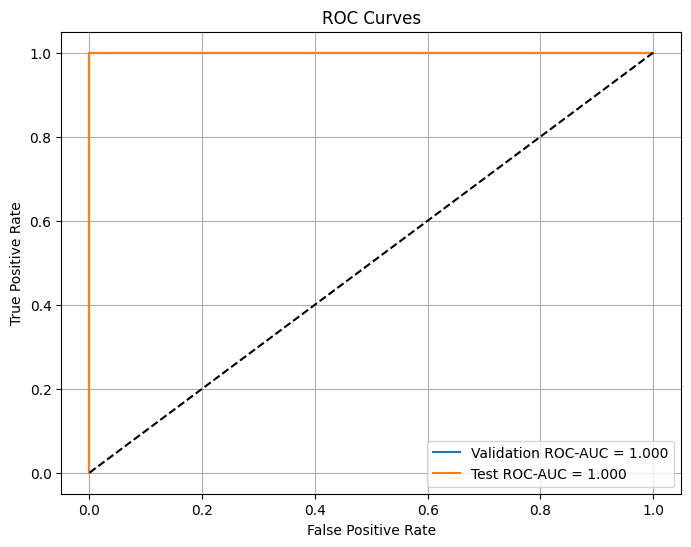

In [44]:
# Plotting ROC Curves
fpr_val, tpr_val, _ = roc_curve(y_val, val_probs)
fpr_test, tpr_test, _ = roc_curve(y_test, test_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr_val, tpr_val, label=f'Validation ROC-AUC = {roc_auc_score(y_val, val_probs):.3f}')
plt.plot(fpr_test, tpr_test, label=f'Test ROC-AUC = {roc_auc_score(y_test, test_probs):.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()


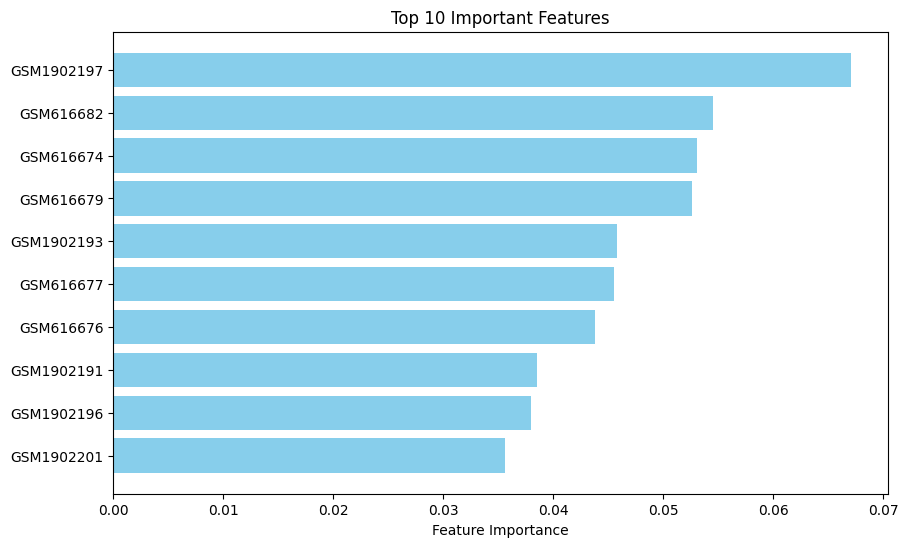

Top 10 Important Features:
        feature  importance
99   GSM1902197    0.067083
14    GSM616682    0.054568
6     GSM616674    0.053112
11    GSM616679    0.052586
95   GSM1902193    0.045799
9     GSM616677    0.045549
8     GSM616676    0.043808
93   GSM1902191    0.038507
98   GSM1902196    0.037981
103  GSM1902201    0.035599


In [45]:
# Featuring Importance Plot
importances = rf.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['feature'][::-1], feat_imp_df['importance'][::-1], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features')
plt.show()

print('Top 10 Important Features:')
print(feat_imp_df)

In [46]:
# Since model shows overfitting, we check for any data leaks
def check_overlap(X_train, X_val, X_test):
    train_idx = set(X_train.index)
    val_idx = set(X_val.index)
    test_idx = set(X_test.index)

    overlap_train_val = train_idx.intersection(val_idx)
    overlap_train_test = train_idx.intersection(test_idx)
    overlap_val_test = val_idx.intersection(test_idx)

    print(f"Train-Val overlap: {len(overlap_train_val)} samples")
    print(f"Train-Test overlap: {len(overlap_train_test)} samples")
    print(f"Val-Test overlap: {len(overlap_val_test)} samples")

    if any([overlap_train_val, overlap_train_test, overlap_val_test]):
        print("WARNING: Data leakage detected! Some samples appear in multiple splits.")
    else:
        print("No overlap detected between splits. No data leakage by index.")

In [47]:
check_overlap(X_train, X_val, X_test)

Train-Val overlap: 0 samples
Train-Test overlap: 0 samples
Val-Test overlap: 0 samples
No overlap detected between splits. No data leakage by index.


In [48]:
# Using Stratified K-Fold to ensure each fold has representative proportions of each class and to provide a more reliable estimate of model generalization performance
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

def cross_validate_model(X, y, n_splits=5, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    accuracies = []
    aucs = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        rf = RandomForestClassifier(n_estimators=100, random_state=random_state, class_weight='balanced')
        rf.fit(X_train, y_train)

        preds = rf.predict(X_test)
        probs = rf.predict_proba(X_test)[:, 1]

        acc = accuracy_score(y_test, preds)
        auc = roc_auc_score(y_test, probs)

        accuracies.append(acc)
        aucs.append(auc)

        print(f"Fold {fold} - Accuracy: {acc:.3f}, ROC-AUC: {auc:.3f}")

    print(f"\nMean Accuracy: {np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}")
    print(f"Mean ROC-AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")

In [49]:
cross_validate_model(X, y, n_splits=5, random_state=42)

Fold 1 - Accuracy: 1.000, ROC-AUC: 1.000
Fold 2 - Accuracy: 1.000, ROC-AUC: 1.000
Fold 3 - Accuracy: 1.000, ROC-AUC: 1.000
Fold 4 - Accuracy: 1.000, ROC-AUC: 1.000
Fold 5 - Accuracy: 1.000, ROC-AUC: 1.000

Mean Accuracy: 1.000 ± 0.000
Mean ROC-AUC: 1.000 ± 0.000


In [50]:
import joblib

# Saving model after training
joblib.dump(rf, 'random_forest_model.joblib')

['random_forest_model.joblib']